In [1]:
!pip -q install pandas numpy scikit-learn matplotlib seaborn joblib

# **Import libraries**

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

import joblib


# **Load dataset files**

In [3]:
DATA_DIR = "/kaggle/input/ieeecis-fraud-detection" 

train_trn = pd.read_csv(os.path.join(DATA_DIR, "train_transaction.csv"))
train_id  = pd.read_csv(os.path.join(DATA_DIR, "train_identity.csv"))
test_trn  = pd.read_csv(os.path.join(DATA_DIR, "test_transaction.csv"))
test_id   = pd.read_csv(os.path.join(DATA_DIR, "test_identity.csv"))
sub       = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

print(train_trn.shape, train_id.shape, test_trn.shape, test_id.shape, sub.shape)


(590540, 394) (144233, 41) (506691, 393) (141907, 41) (506691, 2)


# **Merge transaction + identity**

In [4]:
train = train_trn.merge(train_id, on="TransactionID", how="left")
test  = test_trn.merge(test_id,  on="TransactionID", how="left")

print("Train:", train.shape)
print("Test :", test.shape)


Train: (590540, 434)
Test : (506691, 433)


# **Dataset overview**

In [5]:
train.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [7]:
print("Target distribution (isFraud):")
print(train["isFraud"].value_counts())
print("\nFraud rate:", train["isFraud"].mean())

Target distribution (isFraud):
isFraud
0    569877
1     20663
Name: count, dtype: int64

Fraud rate: 0.03499000914417313


# **Missing values quick view (top 25)**

In [8]:
missing = train.isna().mean().sort_values(ascending=False)
missing.head(25)

id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
D7       0.934099
id_18    0.923607
D13      0.895093
D14      0.894695
D12      0.890410
id_04    0.887689
id_03    0.887689
D6       0.876068
id_33    0.875895
id_09    0.873123
D8       0.873123
id_10    0.873123
D9       0.873123
id_30    0.868654
id_32    0.868619
dtype: float64

# **Basic data description**

In [9]:
train.describe(include=[np.number]).T.head(30)

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3134634.750,3282269.500,3429904.25,3.577539e+06
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.00,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,214.000,361.000,512.00,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,150.000,150.000,150.00,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,166.000,226.000,226.00,2.370000e+02
addr1,524834.0,2.907338e+02,1.017411e+02,100.000,204.000,299.000,330.00,5.400000e+02
addr2,524834.0,8.680063e+01,2.690623e+00,10.000,87.000,87.000,87.00,1.020000e+02


# **Data cleaning**

## **Drop very high missing columns**

In [10]:
TARGET = "isFraud"
ID_COL = "TransactionID"

high_missing_cols = missing[missing > 0.95].index.tolist()
print("Columns >95% missing:", len(high_missing_cols))

train_cols_to_drop = [c for c in high_missing_cols if c in train.columns]
test_cols_to_drop  = [c for c in high_missing_cols if c in test.columns]

train_reduced = train.drop(columns=train_cols_to_drop)
test_reduced  = test.drop(columns=test_cols_to_drop)

print("Train shape:", train_reduced.shape)
print("Test shape :", test_reduced.shape)

Columns >95% missing: 9
Train shape: (590540, 425)
Test shape : (506691, 433)


# **EDA and visualization**

## **Target distribution plot**

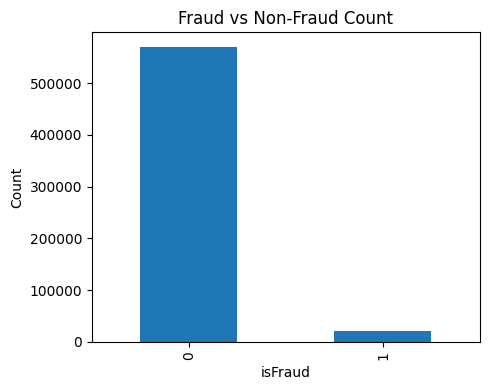

In [11]:
plt.figure(figsize=(5,4))
train_reduced[TARGET].value_counts().plot(kind="bar")
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## **Transaction amount distribution**

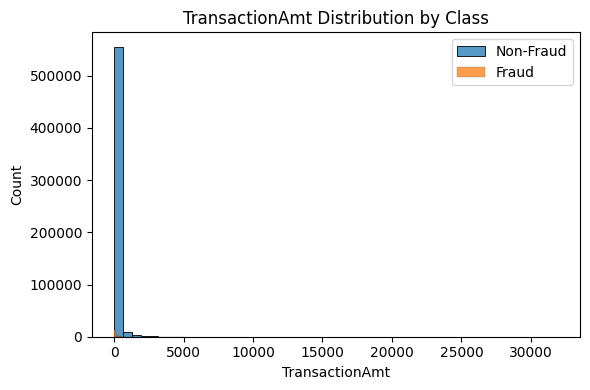

In [12]:
if "TransactionAmt" in train_reduced.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(train_reduced.loc[train_reduced[TARGET]==0, "TransactionAmt"], bins=50, kde=False, label="Non-Fraud")
    sns.histplot(train_reduced.loc[train_reduced[TARGET]==1, "TransactionAmt"], bins=50, kde=False, label="Fraud")
    plt.title("TransactionAmt Distribution by Class")
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Correlation heatmap (top numeric columns only)**

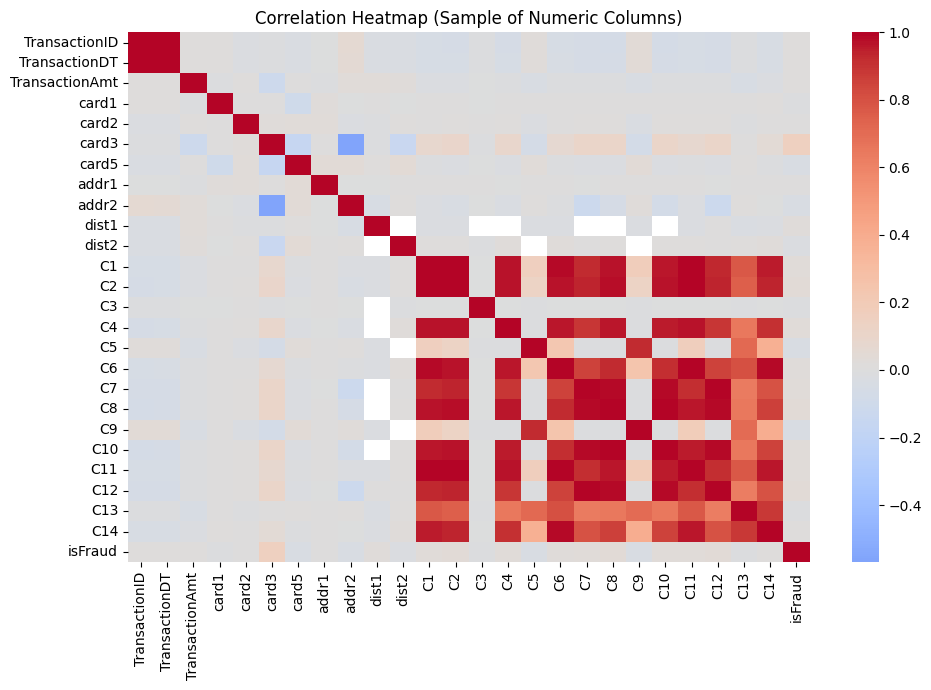

In [13]:
numeric_cols = train_reduced.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [TARGET]]  # remove target

sample_numeric = numeric_cols[:25]  # change if you want
corr = train_reduced[sample_numeric + [TARGET]].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Sample of Numeric Columns)")
plt.tight_layout()
plt.show()

# **Split features and target**

In [14]:
X = train_reduced.drop(columns=[TARGET])
y = train_reduced[TARGET].astype(int)

# Keep IDs for later
train_ids = X[ID_COL].copy()
test_ids  = test_reduced[ID_COL].copy()

# Drop TransactionID from modeling features
X = X.drop(columns=[ID_COL])
X_test_final = test_reduced.drop(columns=[ID_COL])

# **Train-test split**

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_valid.shape)
print("Train fraud rate:", y_train.mean())
print("Valid fraud rate:", y_valid.mean())

(472432, 423) (118108, 423)
Train fraud rate: 0.03498916246147594
Valid fraud rate: 0.0349933958749619


# **Preprocessing pipeline**

## **Identify numeric and categorical columns**

In [16]:
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", len(num_features), "Categorical:", len(cat_features))

Numeric: 394 Categorical: 29


## **Build preprocessors**

In [17]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

# **Advanced Decision Tree model**

In [18]:
dt = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", dt)
])

# **Hyperparameter tuning**

In [19]:
param_grid = {
    "clf__max_depth": [5, 8],
    "clf__min_samples_leaf": [20, 50],
    "clf__ccp_alpha": [0.001, 0.01]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,          
    verbose=2
)

grid.fit(X_train, y_train)

print("Best ROC-AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END clf__ccp_alpha=0.001, clf__max_depth=5, clf__min_samples_leaf=20; total time=  47.2s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=5, clf__min_samples_leaf=20; total time=  47.6s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=5, clf__min_samples_leaf=20; total time=  47.1s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=5, clf__min_samples_leaf=50; total time=  45.9s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=5, clf__min_samples_leaf=50; total time=  47.6s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=5, clf__min_samples_leaf=50; total time=  46.1s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=8, clf__min_samples_leaf=20; total time=  58.0s
[CV] END clf__ccp_alpha=0.001, clf__max_depth=8, clf__min_samples_leaf=20; total time= 1.0min
[CV] END clf__ccp_alpha=0.001, clf__max_depth=8, clf__min_samples_leaf=20; total time= 1.0min
[CV] END clf__ccp_alpha=0.001, clf__max_depth=8, clf__min_samples_leaf=50; total time=  58.2s


# **Model testing on validation set**

## **Predict probabilities**

In [20]:
valid_proba = best_model.predict_proba(X_valid)[:, 1]
valid_pred  = (valid_proba >= 0.5).astype(int)

## **Evaluation metrics**

In [21]:
roc = roc_auc_score(y_valid, valid_proba)
prauc = average_precision_score(y_valid, valid_proba)

print("Validation ROC-AUC:", roc)
print("Validation PR-AUC :", prauc)
print("\nClassification Report:\n", classification_report(y_valid, valid_pred))

Validation ROC-AUC: 0.8404155565121477
Validation PR-AUC : 0.2818741291129271

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    113975
           1       0.12      0.78      0.21      4133

    accuracy                           0.79    118108
   macro avg       0.55      0.78      0.54    118108
weighted avg       0.96      0.79      0.86    118108



## **Confusion matrix**

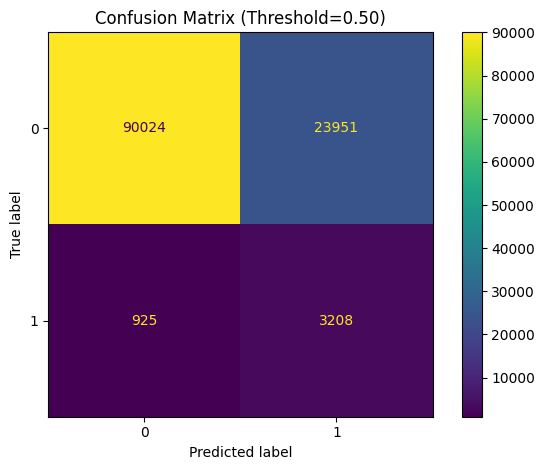

In [22]:
cm = confusion_matrix(y_valid, valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Threshold=0.50)")
plt.tight_layout()
plt.show()


# **Visualizations after training**

## **ROC Curve**

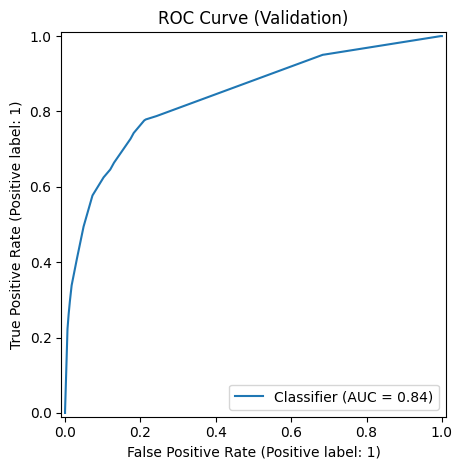

In [23]:
RocCurveDisplay.from_predictions(y_valid, valid_proba)
plt.title("ROC Curve (Validation)")
plt.tight_layout()
plt.show()


## **Precision-Recall Curve**

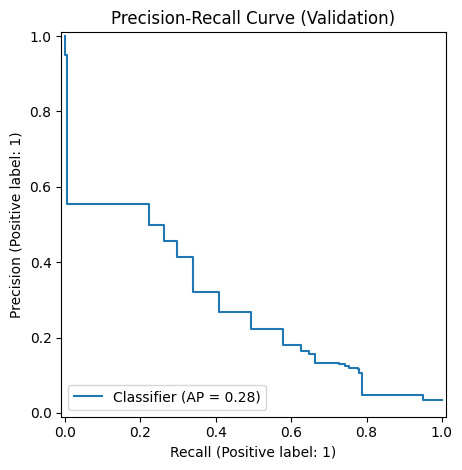

In [24]:
PrecisionRecallDisplay.from_predictions(y_valid, valid_proba)
plt.title("Precision-Recall Curve (Validation)")
plt.tight_layout()
plt.show()


## **Score distribution (fraud vs non-fraud)**

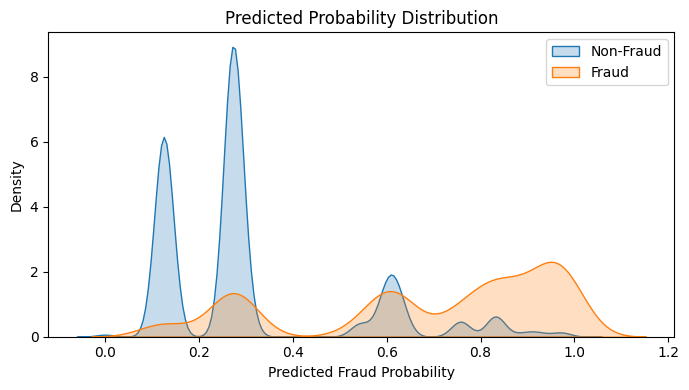

In [25]:
plt.figure(figsize=(7,4))
sns.kdeplot(valid_proba[y_valid==0], label="Non-Fraud", fill=True)
sns.kdeplot(valid_proba[y_valid==1], label="Fraud", fill=True)
plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted Fraud Probability")
plt.legend()
plt.tight_layout()
plt.show()


# **A better threshold**

In [26]:
thresholds = np.linspace(0.01, 0.99, 99)
best_thr = 0.5
best_f1 = -1

from sklearn.metrics import f1_score

for t in thresholds:
    pred_t = (valid_proba >= t).astype(int)
    f1 = f1_score(y_valid, pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print("Best threshold by F1:", best_thr)
print("Best F1:", best_f1)


Best threshold by F1: 0.8400000000000001
Best F1: 0.3718766613503456


### **Plot F1 vs threshold**

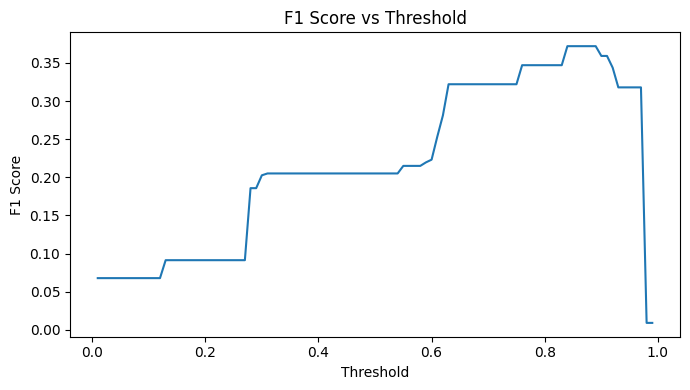

In [27]:
f1s = []
for t in thresholds:
    f1s.append(f1_score(y_valid, (valid_proba >= t).astype(int)))

plt.figure(figsize=(7,4))
plt.plot(thresholds, f1s)
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()


# **Sample rows from validation data**

In [28]:
sample_data = X_valid.sample(5, random_state=42)
sample_labels = y_valid.loc[sample_data.index]

sample_data


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
434162,10972555,459.99,W,15998,555.0,150.0,visa,226.0,debit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582501,15553895,57.95,W,3666,555.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219675,5162949,159.95,W,9112,250.0,150.0,visa,226.0,debit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72352,1618907,100.00,R,16075,514.0,150.0,mastercard,102.0,credit,325.0,...,ie 11.0 for desktop,24.0,1920x1200,match_status:2,T,F,T,T,desktop,Trident/7.0
321982,8007128,92.00,W,8320,476.0,150.0,visa,166.0,debit,444.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
sample_proba = best_model.predict_proba(sample_data)[:, 1]
sample_pred = (sample_proba >= 0.5).astype(int)

results = sample_data.copy()
results["Actual_isFraud"] = sample_labels.values
results["Predicted_isFraud"] = sample_pred
results["Fraud_Probability"] = sample_proba

results[["Actual_isFraud", "Predicted_isFraud", "Fraud_Probability"]]

,Actual_isFraud,Predicted_isFraud,Fraud_Probability
434162,0,0,0.125051
582501,0,0,0.125051
219675,0,0,0.125051
72352,0,0,0.272464
321982,0,0,0.272464
